# 0 - Exploratory Data Analysis
This section is to look into the time series data
- time series plotting
- heatmap plotting

In [ ]:
# connect to gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive

/gdrive


In [1]:
import datetime as dt
dt.datetime.strptime('21-1-2013', '%d-%m-%Y')
parser = lambda date: pd.datetime.strptime(date, '%Y-%m-%d')

In [2]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

df_call = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/KJY/Data Science/Data_Scientist_Position_at_Etiqa_Insurance_Singapore/case_data_calls.csv', 
                      delimiter=';',
                      parse_dates=True,)
df_res = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/KJY/Data Science/Data_Scientist_Position_at_Etiqa_Insurance_Singapore/case_data_reservations.csv',
                     delimiter=';', 
                     parse_dates=True,)

# standardize the date format
df_call['date'] = pd.to_datetime(df_call['date'], format='%d-%m-%Y')
df_res['date'] = pd.to_datetime(df_res['date'], format='%d-%m-%Y')


In [3]:
df_res.head()

,date,reservations_2months_advance,total_reservations,summer_break,christmas_break,special_day
0,2014-01-01,1494,7794,0,1,1
1,2014-01-02,2891,20074,0,1,0
2,2014-01-03,2790,17905,0,1,0
3,2014-01-04,2504,10880,0,0,0
4,2014-01-05,1522,8333,0,0,0


In [4]:
print(df_call.shape, df_res.shape)

(1155, 3) (790, 6)


In [5]:
# check whether there is duplicate in dates
check_call = df_call['date'].groupby(df_call['date']).nunique().sum()
check_res = df_res['date'].groupby(df_res['date']).nunique().sum()
print(check_call, check_res)

1155 790


In [6]:
# merge both dataframes for easy manipulation
merge_df = df_call.merge(df_res, how='outer', on='date', validate='one_to_one')
merge_df.set_index('date', drop=True, inplace=True)

In [7]:
merge_df

,calls,weekday,reservations_2months_advance,total_reservations,summer_break,christmas_break,special_day
date,,,,,,,
2013-01-01,2429,2,NaN,NaN,NaN,NaN,NaN
2013-01-02,3881,3,NaN,NaN,NaN,NaN,NaN
2013-01-03,3560,4,NaN,NaN,NaN,NaN,NaN
2013-01-04,3155,5,NaN,NaN,NaN,NaN,NaN
2013-01-05,1538,6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2016-02-25,5690,4,4713.0,33309.0,0.0,0.0,0.0
2016-02-26,5799,5,5204.0,34350.0,0.0,0.0,0.0
2016-02-27,3949,6,5135.0,23656.0,0.0,0.0,0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f86be790a50>,
      dtype=object)

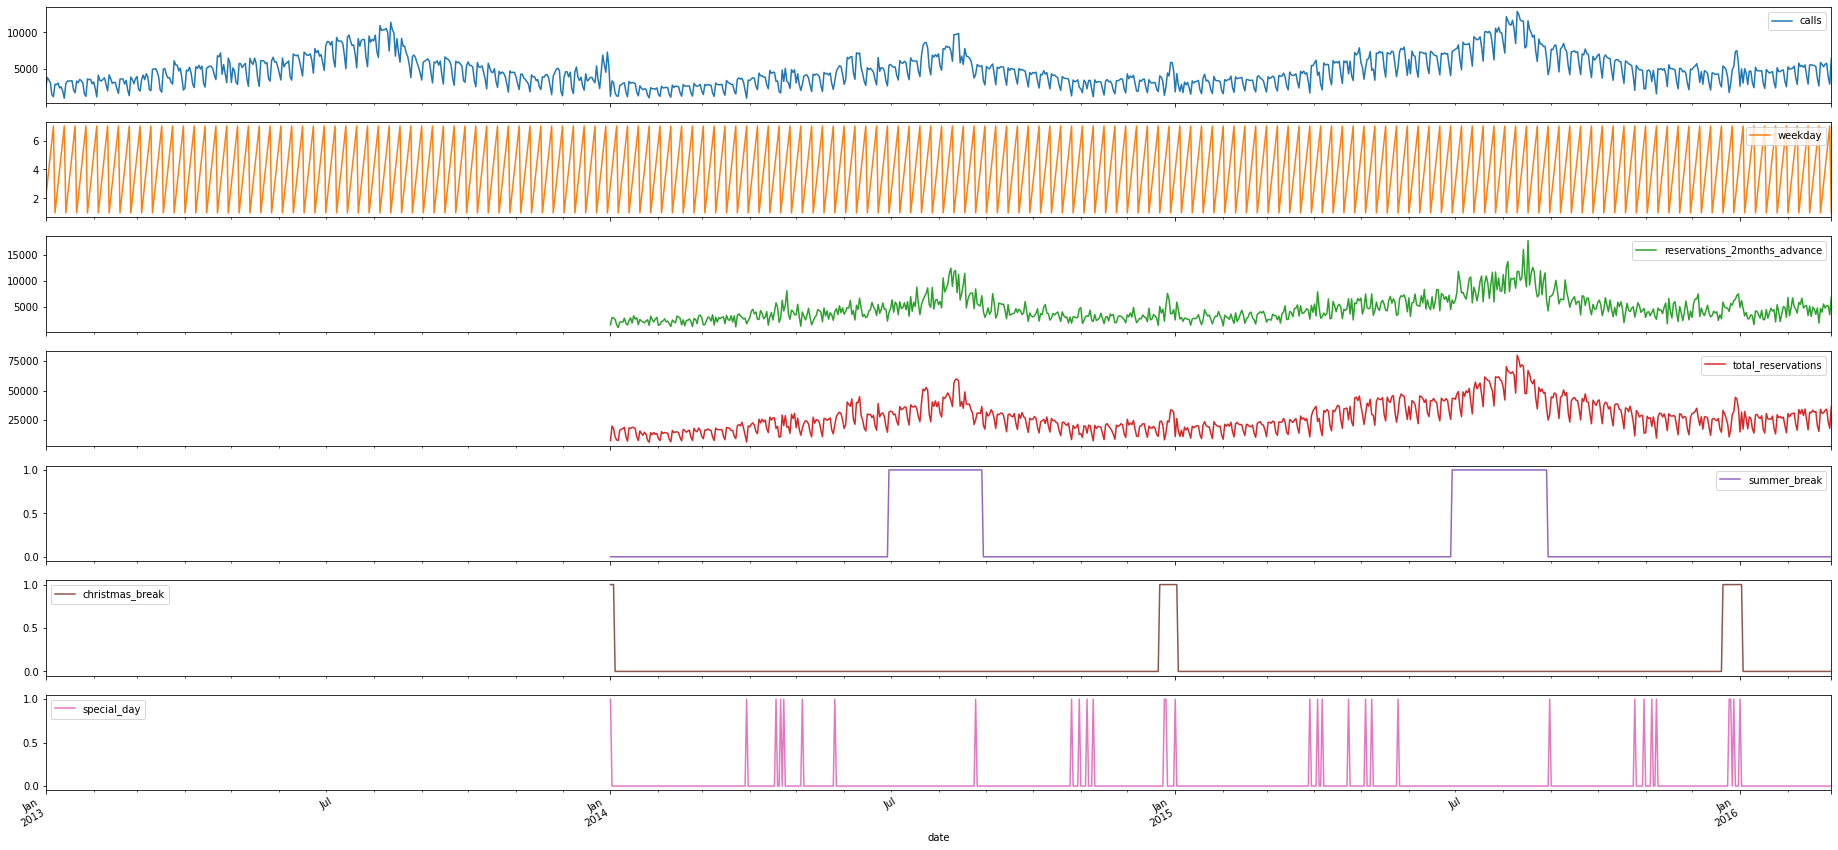

In [8]:
merge_df.plot(subplots=True, figsize=(32,16))

In [9]:
# Try resampling to weekly and monthly data
merge_df_week = merge_df.resample('W').mean()
merge_df_month = merge_df.resample('M').mean()

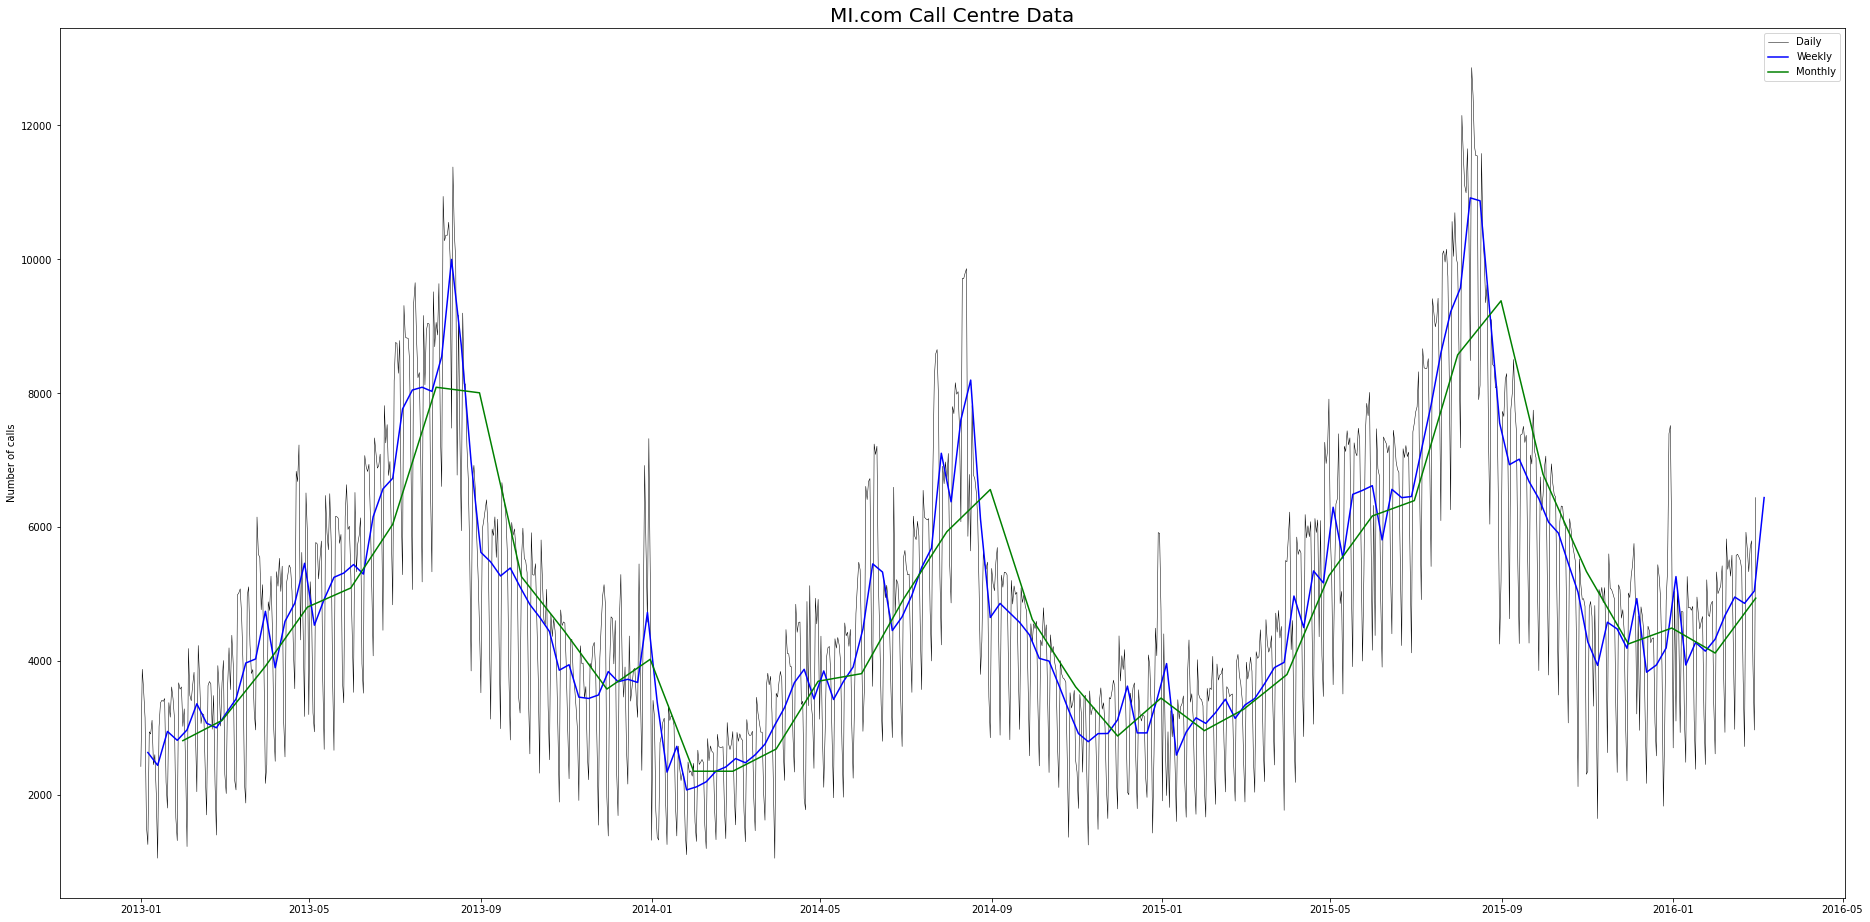

In [10]:
# Plot daily, weekly and monthly data
fig, ax = plt.subplots(figsize=(32,16))

ax.plot(merge_df.index, merge_df['calls'], label='Daily', linestyle='-', linewidth=0.5, color='black')
ax.plot(merge_df_week.index, merge_df_week['calls'], label='Weekly', color='blue')
ax.plot(merge_df_month.index, merge_df_month['calls'], label='Monthly', color='green')
ax.set_ylabel('Number of calls')
ax.set_title('MI.com Call Centre Data', fontsize=20)
ax.legend()

Text(0.5, 1.0, 'Average Calls (in thousands)')

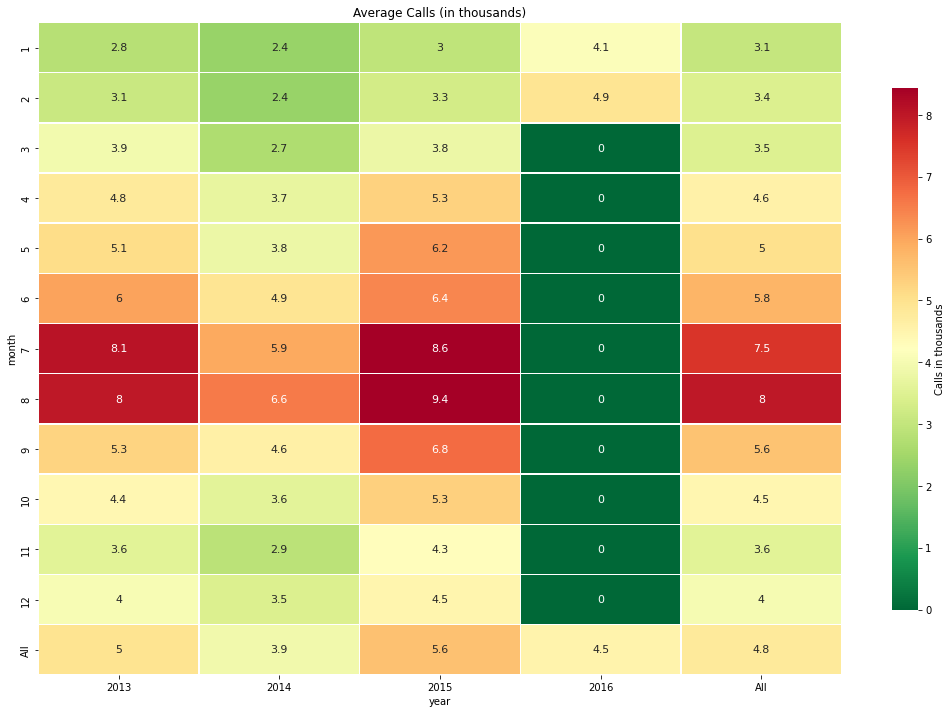

In [12]:
# Plot a heatmap
import seaborn as sns

merge_df['month'] = merge_df.index.month
merge_df['year'] = merge_df.index.year
merge_df['new_calls'] = merge_df['calls']/1000
new_df = pd.pivot_table(merge_df, values='new_calls', index=['month'], columns=['year'], fill_value=0, margins=True)

fig, ax = plt.subplots(figsize=(18, 12))
hm = sns.heatmap(new_df, cmap='RdYlGn_r', robust=True, annot=True, linewidths=0.5, annot_kws={'size':11},
                 cbar_kws={'shrink':0.8, 'label':'Calls in thousands'})
plt.title('Average Calls (in thousands)')

In [13]:
merge_df.index = merge_df.index.astype(np.int64) // 10**9

In [14]:
merge_df.index

Int64Index([1356998400, 1357084800, 1357171200, 1357257600, 1357344000,
            1357430400, 1357516800, 1357603200, 1357689600, 1357776000,
            ...
            1455926400, 1456012800, 1456099200, 1456185600, 1456272000,
            1456358400, 1456444800, 1456531200, 1456617600, 1456704000],
           dtype='int64', name='date', length=1155)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                  calls   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     31.14
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           2.99e-08
Time:                        09:29:29   Log-Likelihood:                -10466.
No. Observations:                1155   AIC:                         2.094e+04
Df Residuals:                    1153   BIC:                         2.095e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.194e+04   3000.176     -3.979      0.0

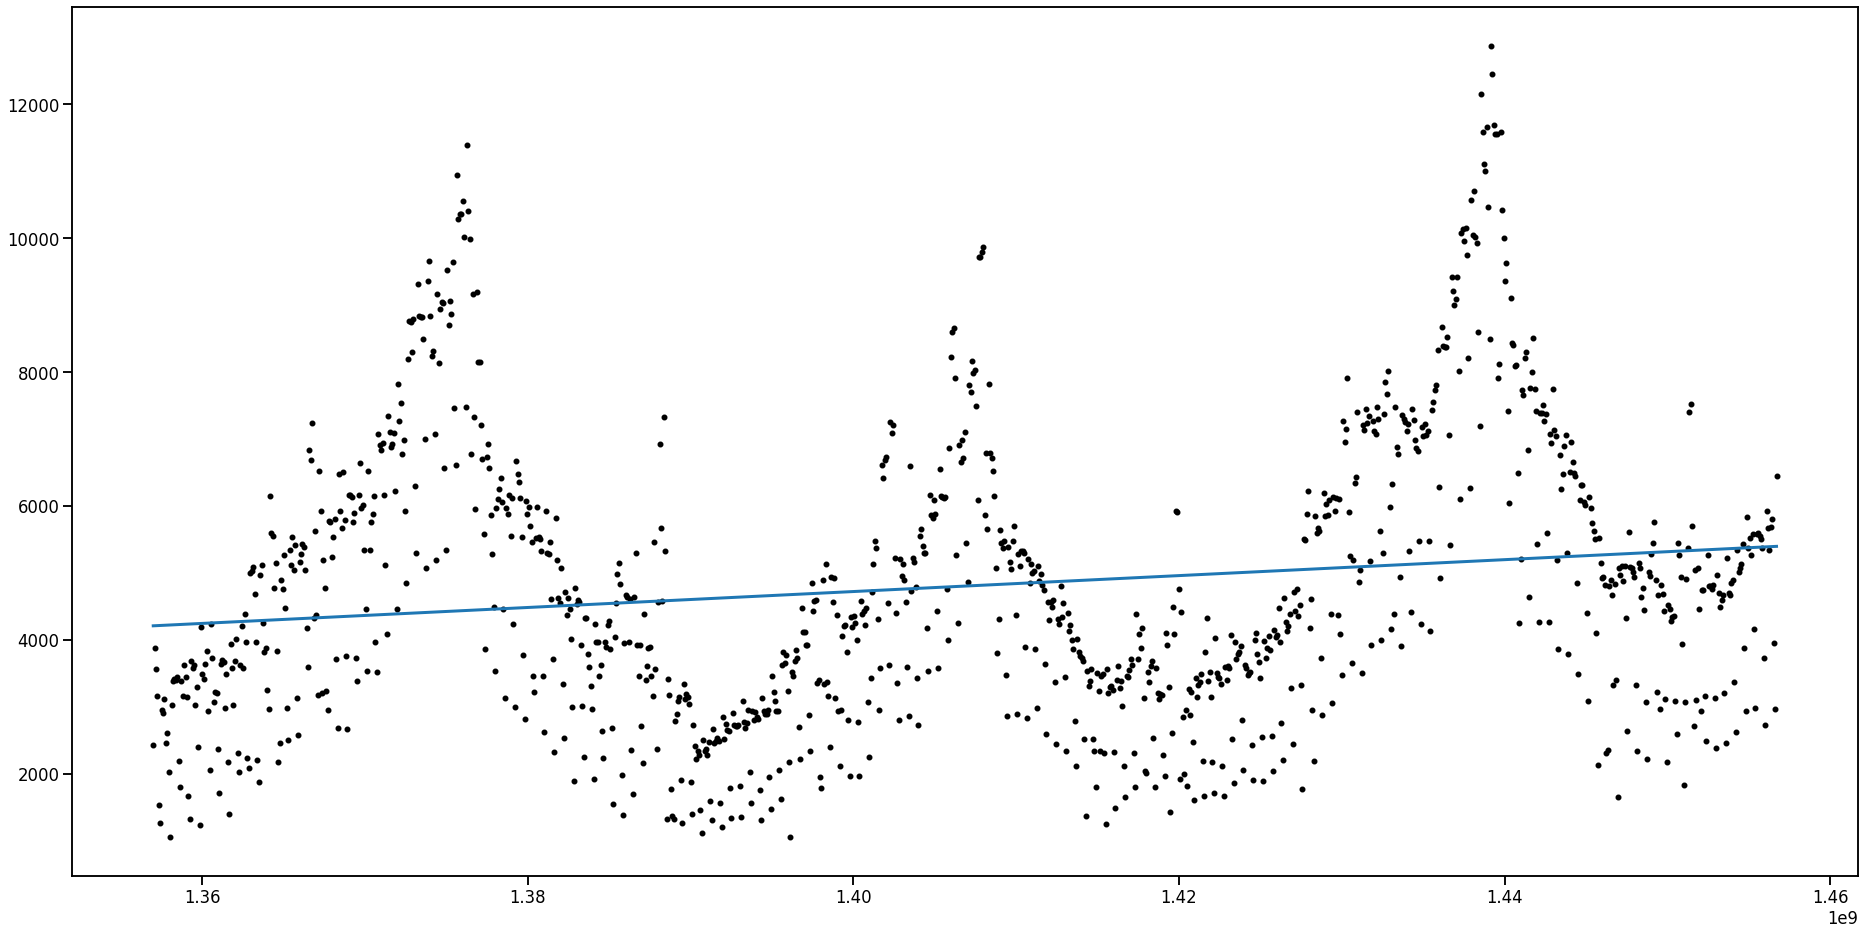

In [16]:
import statsmodels.api as sm

x_value = sm.add_constant(merge_df.index)
model = sm.OLS(merge_df['calls'], x_value)
results = model.fit()

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(32, 16))
ax.scatter(merge_df.index, merge_df['calls'], color='black', s=20)
y_predict = results.params[0] + results.params[1]*merge_df.index
plt.plot(merge_df.index, y_predict, linewidth=3)

print(results.summary())


#sns.lmplot(x=merge_df.index, y='calls', data=merge_df, lowess=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


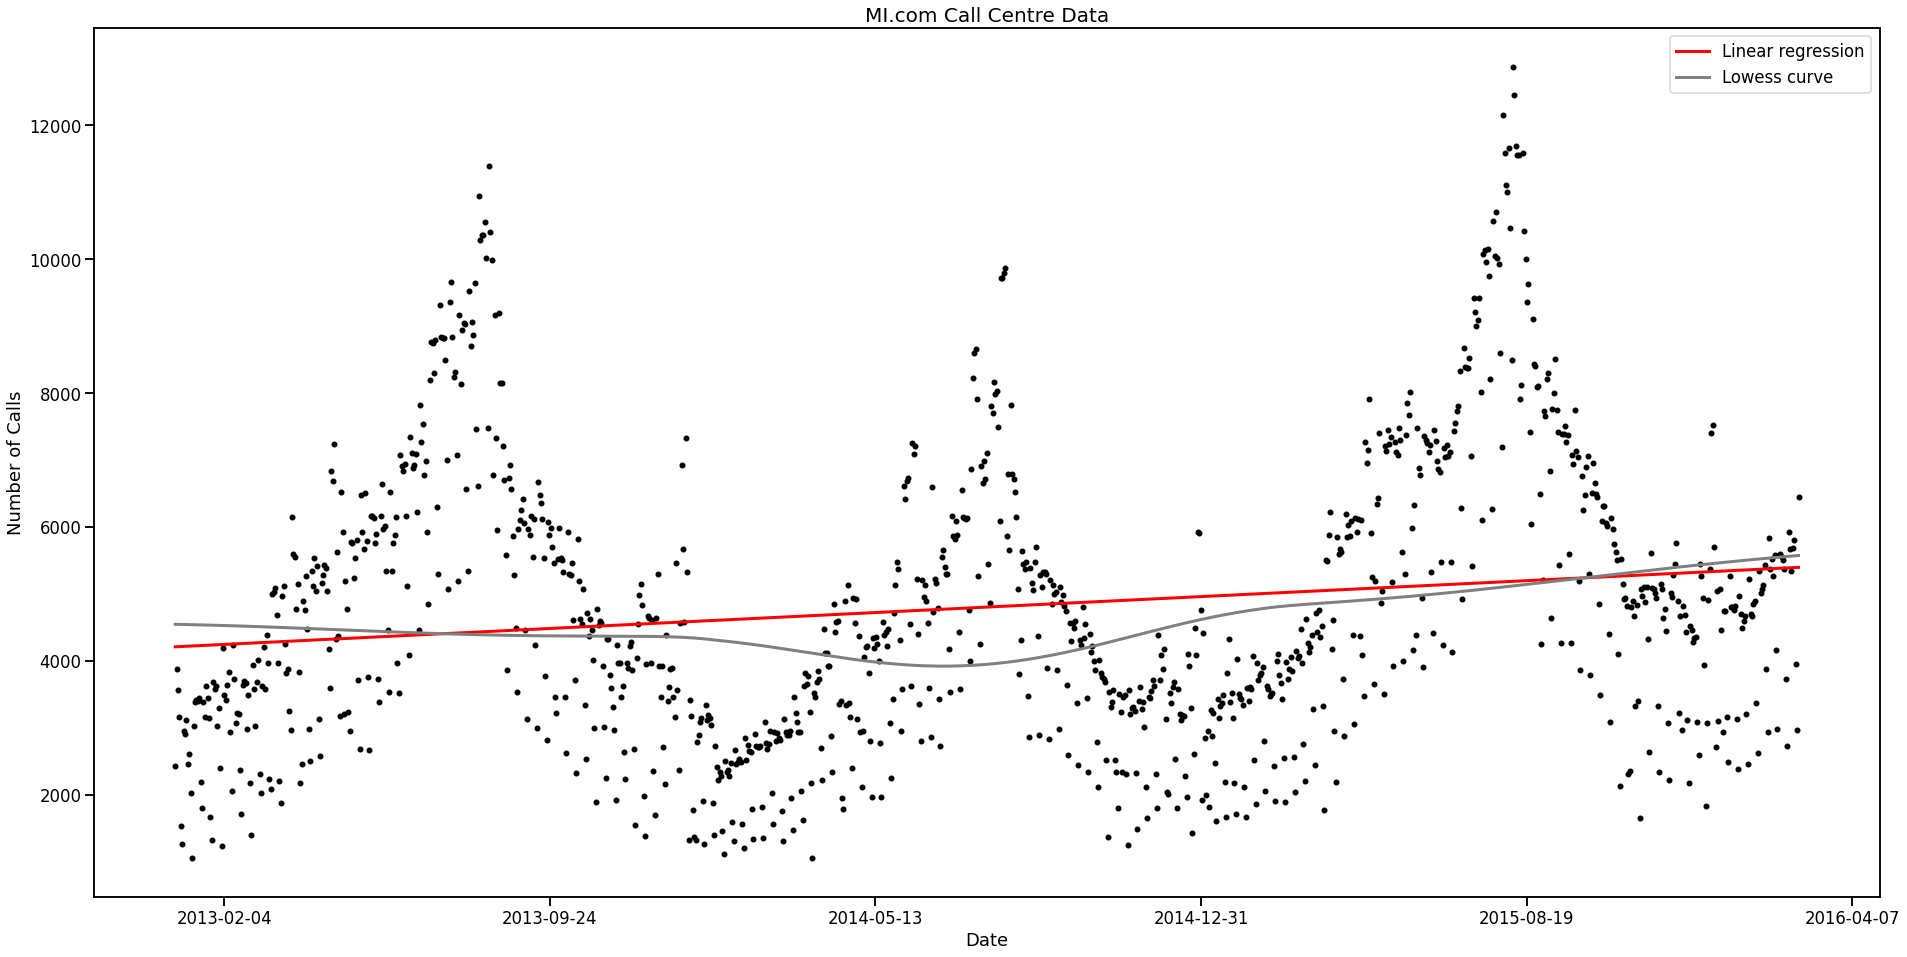

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import seaborn as sns
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(32, 16))
ax.scatter(merge_df.index, merge_df['calls'], color='black', s=20)
sns.regplot(merge_df.index, 'calls', data=merge_df, ci=None, scatter=False, fit_reg=True, color='red', label='Linear regression', line_kws={'linewidth':3})
sns.regplot(merge_df.index, 'calls', data=merge_df, ci=None, scatter=False, lowess=True, color='grey', label='Lowess curve', line_kws={'linewidth':3})

xticks = ax.get_xticks()
xticks_dates = [dt.datetime.fromtimestamp(x).strftime('%Y-%m-%d') for x in xticks]
ax.set_xticklabels(xticks_dates)

ax.set_title('MI.com Call Centre Data', fontsize=20)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Calls')
ax.legend()
plt.show()

fig.savefig('TS_linearlowess.png', quality=50, DPI=300)
files.download('TS_linearlowess.png')

In [ ]:
# export as picke
merge_df.to_pickle('/content/drive/Othercomputers/My MacBook Pro/KJY/Data Science/Data_Scientist_Position_at_Etiqa_Insurance_Singapore/0-df.pkl')

In [ ]:
#